In [1]:
!pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot, cm
from matplotlib import pyplot as plt
import pydicom
import math
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt  
from sklearn import metrics
from statsmodels.stats.proportion import proportion_confint
from Functions.auc_delong_xu import auc_ci_Delong

In [3]:
#read file with predictions from 5 runs
pred = pd.read_csv('C:/Users/Schule/OneDrive/Studium ZHAW/Bachelorarbeit/5facheCV/deepensemble.csv', sep = ";")
pred

,pat_id,y_test,y_pred_1,y_prob_1,cat_cross_1,y_pred_2,y_prob_2,cat_cross_2,y_pred_3,y_prob_3,cat_cross_3,y_pred_4,y_prob_4,cat_cross_4,y_pred_5,y_prob_5,cat_cross_5,y_prob_mean,y_pred,prob_var
0,b'214',1,1,0.648868,NaN,1,0.787003,0.644894,0,0.426100,0.762409,1,0.734037,0.703254,1,0.665187,0.629985,0.652239,1,0.019043
1,b'530',1,1,0.979525,NaN,0,0.316994,0.644894,1,0.585746,0.762409,1,0.646319,0.703254,1,0.636919,0.629985,0.633100,1,0.055591
2,b'458',1,1,0.993579,NaN,1,0.962975,0.644894,1,0.697914,0.762409,1,0.830974,0.703254,1,0.729043,0.629985,0.842897,1,0.017812
3,b'396',1,1,0.950613,NaN,1,0.771483,0.644894,1,0.806141,0.762409,1,0.606691,0.703254,1,0.696687,0.629985,0.766323,1,0.016477
4,b'233',1,0,0.156692,NaN,0,0.315955,0.644894,0,0.325972,0.762409,0,0.369222,0.703254,1,0.590114,0.629985,0.351591,0,0.024279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,b'108',0,0,0.486297,NaN,1,0.797980,0.629122,1,0.864499,0.688893,0,0.427547,0.618755,1,0.552668,0.675023,0.625798,1,0.037684
504,b'184',0,0,0.298177,NaN,0,0.486809,0.629122,0,0.194467,0.688893,0,0.193021,0.618755,0,0.195967,0.675023,0.273688,0,0.016211
505,b'260',0,1,0.700794,NaN,1,0.599810,0.629122,0,0.324655,0.688893,1,0.632402,0.618755,1,0.827856,0.675023,0.617103,1,0.034370
506,b'127',0,1,0.601724,NaN,0,0.247425,0.629122,1,0.711224,0.688893,1,0.646688,0.618755,1,0.500378,0.675023,0.541488,1,0.032917


In [4]:
cm = confusion_matrix(pred.y_test, pred.y_pred)
lower_acc, upper_acc = proportion_confint(sum(np.diag(cm)), np.sum(cm), 0.05, method = 'wilson')
ci_acc = np.array([lower_acc, upper_acc])

auc, auc_var, ci_auc = auc_ci_Delong(
    y_true=pred.y_test,
    y_scores=pred.y_prob_mean)

sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
lower_sens, upper_sens = proportion_confint(cm[1,1], (cm[1,1]+cm[1,0]), 0.05, method = 'wilson')
ci_sens = np.array([lower_sens, upper_sens])

specificity = cm[0,0]/(cm[0,0]+cm[0,1])
lower_spec, upper_spec = proportion_confint(cm[0,0], (cm[0,0]+cm[0,1]), 0.05, method = 'wilson')
ci_spec = np.array([lower_spec, upper_spec])

nll = log_loss(pred.y_test, pred.y_prob_mean)

print("Accuracy: ", round((np.mean(pred.y_pred == pred.y_test)),3), ' CI:', np.round(ci_acc,4) )
print("AUC: ", round(auc, 3), 'CI:', np.round(ci_auc, 3))
print("Sensitivity: ", round(sensitivity,3), 'CI:', np.round(ci_sens, 3))
print("Specificity: ", round(specificity,3), 'CI:', np.round(ci_spec, 3))
print("NLL: ", round(nll,4))
print("Confusion matrix: \n", 
      cm)
print("Normalized Confusion matrix: \n", 
      np.round(confusion_matrix(pred.y_test, pred.y_pred, normalize = 'true'),3))

Accuracy:  0.656  CI: [0.6132 0.6955]
AUC:  0.597 CI: [0.543 0.651]
Sensitivity:  0.795 CI: [0.75  0.834]
Specificity:  0.344 CI: [0.274 0.421]
Confusion matrix: 
 [[ 54 103]
 [ 72 279]]
Normalized Confusion matrix: 
 [[0.344 0.656]
 [0.205 0.795]]


In [4]:
correct_class = pred.loc[lambda pred: pred['y_test'] == pred['y_pred']]

print("correct_class: " , correct_class['prob_var'].mean())

incorrect_class = pred.loc[lambda pred: pred['y_test'] != pred['y_pred']]
incorrect_class['prob_var'].mean()

print("incorrect_class: " , incorrect_class['prob_var'].mean())

correct_stroke = pred.loc[(pred['y_test']== pred['y_pred']) & (pred['y_test'] == 1)]
correct_stroke['prob_var'].mean()

print("correct_stroke: " , correct_stroke['prob_var'].mean())

incorrect_stroke = pred.loc[(pred['y_test'] != pred['y_pred']) & (pred['y_test'] == 1)]
incorrect_stroke['prob_var'].mean()

print("incorrect_stroke: " , incorrect_stroke['prob_var'].mean())

correct_tia = pred.loc[(pred['y_test']== pred['y_pred']) & (pred['y_test'] == 0)]
correct_tia['prob_var'].mean()

print("correct_tia: " , correct_tia['prob_var'].mean())

incorrect_tia = pred.loc[(pred['y_test'] != pred['y_pred']) & (pred['y_test'] == 0)]
incorrect_tia['prob_var'].mean()

print("incorrect_tia: " , incorrect_tia['prob_var'].mean())

correct_class:  0.030957815543543543
incorrect_class:  0.03737061514857143
correct_stroke:  0.031945236322580645
incorrect_stroke:  0.052506570625
correct_tia:  0.02585614151851852
incorrect_tia:  0.026790141417475734


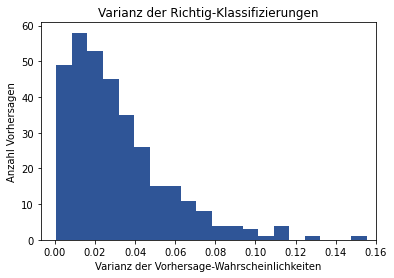

In [12]:
plt.hist(correct_class['prob_var'], bins = 20, color = "#2F5597")
plt.title("Varianz der Richtig-Klassifizierungen")
plt.xlabel("Varianz der Vorhersage-Wahrscheinlichkeiten")
plt.ylabel("Anzahl Vorhersagen")
plt.xlim(right = 0.16)
fig1 = plt.gcf()
plt.show()
p = '~/Histogramm_Varianzen_korrekte_Klasse.png'
fig1.savefig(p, dpi = 300,bbox_inches='tight')

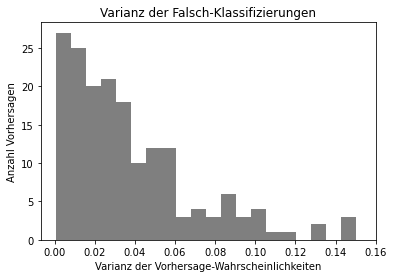

In [11]:
plt.hist(incorrect_class['prob_var'], bins = 20, color = '#7F7F7F')
plt.title("Varianz der Falsch-Klassifizierungen")
plt.xlabel("Varianz der Vorhersage-Wahrscheinlichkeiten")
plt.ylabel("Anzahl Vorhersagen")
plt.xlim(right = 0.16)
fig1 = plt.gcf()
plt.show()
p = '~/Histogramm_Varianzen_inkorrekte_Klasse.png'
fig1.savefig(p, dpi = 300,bbox_inches='tight')

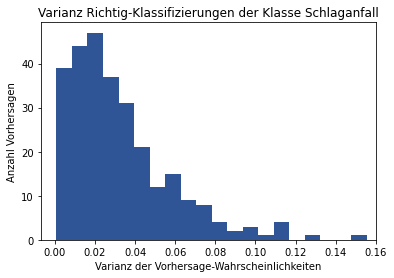

In [10]:
plt.hist(correct_stroke['prob_var'], bins = 20, color = "#2F5597")
plt.title("Varianz Richtig-Klassifizierungen der Klasse Schlaganfall")
plt.xlabel("Varianz der Vorhersage-Wahrscheinlichkeiten")
plt.ylabel("Anzahl Vorhersagen")
plt.xlim(right = 0.16)
fig1 = plt.gcf()
plt.show()
p = '~/Histogramm_Varianzen_korrekte_Stroke.png'
fig1.savefig(p, dpi = 300,bbox_inches='tight')

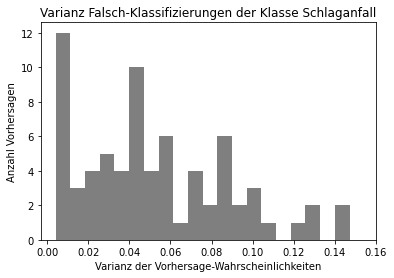

In [9]:
plt.hist(incorrect_stroke['prob_var'], bins = 20, color = '#7F7F7F')
plt.title("Varianz Falsch-Klassifizierungen der Klasse Schlaganfall")
plt.xlabel("Varianz der Vorhersage-Wahrscheinlichkeiten")
plt.ylabel("Anzahl Vorhersagen")
plt.xlim(right = 0.16)
fig1 = plt.gcf()
plt.show()
p = '~/Histogramm_Varianzen_inkorrekte_Stroke.png'
fig1.savefig(p, dpi = 300,bbox_inches='tight')

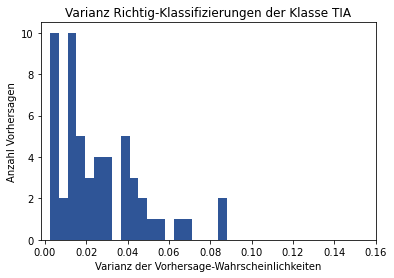

In [8]:
plt.hist(correct_tia['prob_var'], bins = 20, color = "#2F5597")
plt.title("Varianz Richtig-Klassifizierungen der Klasse TIA")
plt.xlabel("Varianz der Vorhersage-Wahrscheinlichkeiten")
plt.ylabel("Anzahl Vorhersagen")
plt.xlim(right = 0.16)
fig1 = plt.gcf()
plt.show()
p = '~/Histogramm_Varianzen_korrekte_TIA.png'
fig1.savefig(p, dpi = 300,bbox_inches='tight')

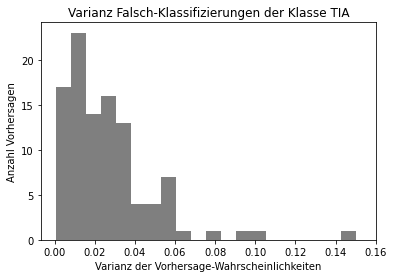

In [7]:
plt.hist(incorrect_tia['prob_var'], bins = 20,  color = '#7F7F7F')
plt.title("Varianz Falsch-Klassifizierungen der Klasse TIA")
plt.xlabel("Varianz der Vorhersage-Wahrscheinlichkeiten")
plt.ylabel("Anzahl Vorhersagen")
plt.xlim(right = 0.16)
fig1 = plt.gcf()
plt.show()
p = '~/Histogramm_Varianzen_inkorrekt_TIA.png'
fig1.savefig(p, dpi = 300,bbox_inches='tight')